# Requirements
- You have now successfully trained different model types. As a last excercise the focus is on the prediction of time series data via Long Short Term Memory. The theoretical concepts are mainly discussed in lecture six.
- In the source code, gaps, which are marked with **TODO**, have to be filled and theoretical questions have to be answered. For experimentation, further changes to the code should be made at the end, if requested. In total we got **10 TODO**s
- Please notice that you maybe need further processing of the raw data or change parts of the code to successfully complete it.

---

## Load modules & Check PyTorch

In [30]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim


import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for noramlization
from sklearn.preprocessing import MinMaxScaler


Right at the beginning: check if a cuda compatible GPU is available in your computer. If so, set device = cuda:0, which means that later all calculations will be performed on the graphics card.  If no GPU is available, the calculations will run on the CPU, which is also absolutely sufficient for the examples in these exercises.

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

No GPU available.


---

# Recurrent Neural Networks

Just as people do not have to think again each time about the things they have already learned, it is also possible to teach neural networks to recall knowledge they were being taught. This is done in so-called Recurrent Neural Networks (RNNs) with loops inside, which allow information to be retained. Currently the most used architectures of RNNs are Long short-term memory (LSTM) networks. LSTMs are RNNs that overcome the problem of long-term dependencies and thus have achieved the most state-of-the-art results in this area. In this exercise we will look at how to use LSTMs to predict future values using time series data sets.

## Load & Inspect data

**1. TODO**: You are provided with the tide gauge data for Pellworm in Schleswig-Holstein, Germany. The data is stored in the file pellworm data.csv, where each row contains the information **[yyyy mm dd hh mm
height]**. Read in the data set (like in previous exercises) and plot the height against time. Since the data set is very large, it is sufficient for this exercise to use only every 1000th height value

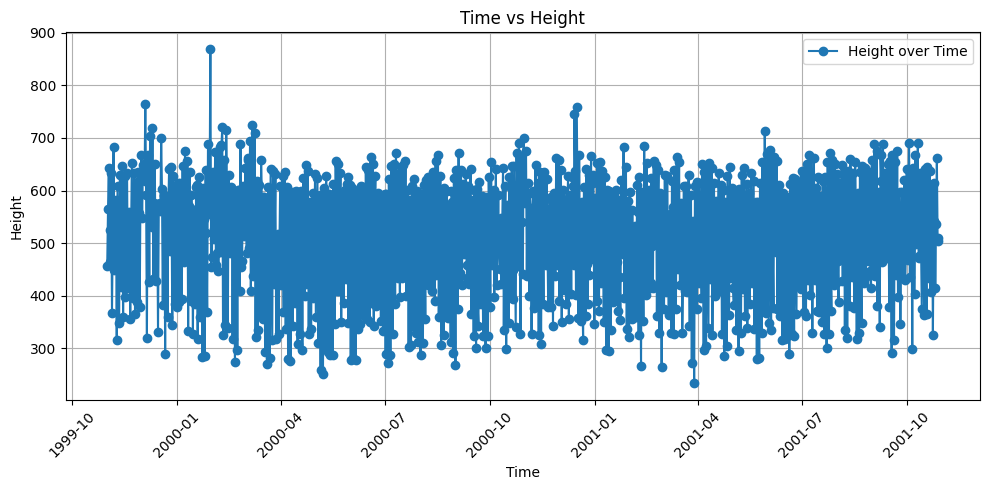

In [ ]:
import datetime
# Read pellworm data
# TODO start**    

# Path to WHO data
data_path = '../data/pellworm_data.csv'

# Read csv sheet with pandas
df = pd.read_csv(data_path)

df = df.dropna()

# Get numpy out of pandas dataframe
data = df.values

data = data[::1000]

# data = ??? 

def plot_time_height(data):
    time_series = []
    heights = []
    
    for row in data:
        year, month, day, hour, minute, height = map(int, row)
        
        # Handle hour 24 case by rolling over to the next day at 00:00
        if hour == 24:
            hour = 0
            day += 1
            
            # Handle month/day overflow
            try:
                new_date = datetime.date(year, month, day)
            except ValueError:
                month += 1
                day = 1
                if month > 12:
                    month = 1
                    year += 1
        
        # Validate time values
        if not (1 <= month <= 12):
            print(f"Invalid month: {month} in row {row}")
            continue
        if not (1 <= day <= 31):
            print(f"Invalid day: {day} in row {row}")
            continue
        if not (0 <= hour <= 23):
            print(f"Invalid hour: {hour} in row {row}")
            continue
        if not (0 <= minute <= 59):
            print(f"Invalid minute: {minute} in row {row}")
            continue
        
        time_series.append(datetime.datetime(year, month, day, hour, minute))
        heights.append(height)
    
    if not time_series:
        print("No valid data points to plot.")
        return
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(time_series, heights, marker='o', linestyle='-', label='Height over Time')
    
    # Formatting
    plt.xlabel('Time')
    plt.ylabel('Height')
    plt.title('Time vs Height')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_time_height(data)

**2. TODO**: In addition, load the flight dataset, which is part of the seaborn library. Plot here the number of passengers against time.

['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'dowjones', 'exercise', 'flights', 'fmri', 'geyser', 'glue', 'healthexp', 'iris', 'mpg', 'penguins', 'planets', 'seaice', 'taxis', 'tips', 'titanic']


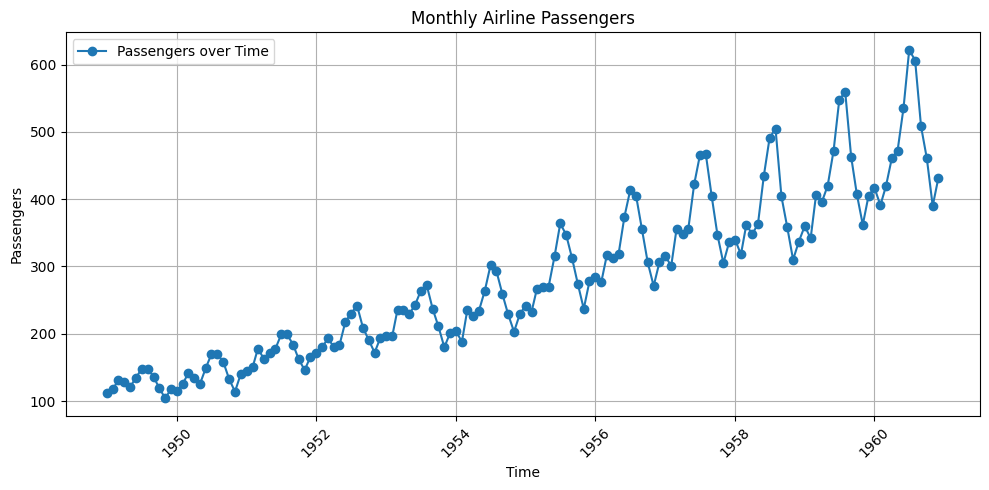

In [ ]:
# Load flight passenger data from seaborn library
# there are some datasets in the seaborn library included
print(sns.get_dataset_names())

# TODO** 
# we can use e.g. the flight dataset
flight_data = sns.load_dataset("flights")

# data = flight_data.values

def plot_flight_data(data):
    month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                  'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    
    time_series = []
    passengers = []
    
    for row in data:
        year = int(row[0])
        month_str = row[1]
        passenger_count = int(row[2])
        
        if month_str not in month_dict:
            print(f"Invalid month: {month_str} in row {row}")
            continue
        
        month = month_dict[month_str]
        time_series.append(datetime.datetime(year, month, 1))
        passengers.append(passenger_count)
    
    if not time_series:
        print("No valid data points to plot.")
        return
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(time_series, passengers, marker='o', linestyle='-', label='Passengers over Time')
    
    # Formatting
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.title('Monthly Airline Passengers')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_flight_data(data)

**3. TODO**: Explain briefly the characteristic differences between the time series (periodicity?, trends?).

...

We assume that the time series are equidistant, i.e. that all data points have the same distances. This means that we only need height resp. passenger data for the following steps. Decide which data set you want to use in this exercise.

---

## Data preprocessing

Since we want to predict future data points in this exercise, we first cut our time series at the end and treat this cut-off part as test data. 

**4. TODO**: Set a suitable size for the *test_data* so that enough data remains for training and validation (*trva_data*).

In [19]:
# Cut the end of the time series as test data
# TODO start** 
test_data_size = 100

# trva = train and val
trva_data = data[:-test_data_size]
test_data = data[-test_data_size:] 

print('Length of train data:', len(trva_data))
print('Length of test data:', len(test_data))

Length of train data: 949
Length of test data: 100


The *trva_data* are now normalized and converted to torch tensors, as known from the previous exercises. However, the next step is special by creating sequences from the trva data. Therefore we use the helper function *create_inout_sequences(input data, train window)*, which creates sequences $Input \rightarrow Output$ from the time series
like this (in case train window = 3):

$$[x_{t-2},x_{t-1}, x_t] \rightarrow x_{t+1},$$

The input sequences have the length *train_window* and the output has the length 1. 

**5. TODO**: Define a suitable train window size

In [20]:
# Normalize data with MinMax Scaler

scaler = MinMaxScaler(feature_range=(-1, 1))
trva_data_normalized = scaler.fit_transform(trva_data.reshape(-1, 1))
print(trva_data_normalized[:5])
print(trva_data_normalized[-5:])


[[ 0.998001 ]
 [-0.9890055]
 [-0.9990005]
 [-1.       ]
 [-0.9970015]]
[[-0.992004  ]
 [-0.98001   ]
 [-0.992004  ]
 [-0.94402799]
 [-0.67016492]]


In [21]:
# Convert to Torch Tensor
# view(-1) is similar to reshape for tensor and the array size is inferred for the -1 dimension

trva_data_normalized = torch.FloatTensor(trva_data_normalized).view(-1)

In [22]:
# Create sequences
# Function to create sequences of input (passenger of train_window months) and ...
# ... output passenger of train_window+1 month

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_<label))
    return inout_seq

# Set an appropiate Train window
# TODO start**
train_window = 24

# Create sequences 
trva_inout_seq = create_inout_sequences(trva_data_normalized, train_window)

# Print the first 3 sequences
print(trva_inout_seq[:3])

[(tensor([ 0.9980, -0.9890, -0.9990, -1.0000, -0.9970, -0.5442,  0.9980, -0.9890,
        -0.9990, -0.9840, -0.9540, -0.4353,  0.9980, -0.9890, -0.9980, -0.9910,
        -0.9720, -0.3583,  0.9980, -0.9890, -0.9970, -0.9980, -0.9870, -0.5352]), tensor([0.9980])), (tensor([-0.9890, -0.9990, -1.0000, -0.9970, -0.5442,  0.9980, -0.9890, -0.9990,
        -0.9840, -0.9540, -0.4353,  0.9980, -0.9890, -0.9980, -0.9910, -0.9720,
        -0.3583,  0.9980, -0.9890, -0.9970, -0.9980, -0.9870, -0.5352,  0.9980]), tensor([-0.9890])), (tensor([-0.9990, -1.0000, -0.9970, -0.5442,  0.9980, -0.9890, -0.9990, -0.9840,
        -0.9540, -0.4353,  0.9980, -0.9890, -0.9980, -0.9910, -0.9720, -0.3583,
         0.9980, -0.9890, -0.9970, -0.9980, -0.9870, -0.5352,  0.9980, -0.9890]), tensor([-0.9970]))]


In the following, the sequences are divided into training and validation sequences according to the previous exercises.

In [23]:
# Split train sequences in train and val sequences
# Remember: we ahve already taken test data -> end of time series

sample_num = {'all': len(trva_inout_seq), 
              'train': int(0.8*len(trva_inout_seq)),
              'val': int(0.2*len(trva_inout_seq))}

# idx shuffle
idx = list(range(sample_num['all']))
np.random.shuffle(idx)
# assign idx to each sample
sample_idx = {'all': idx[:], 
              'train': idx[0:sample_num['train']],
              'val': idx[sample_num['train']:]}

train_inout_seq = [ trva_inout_seq[i] for i in sample_idx['train']]
val_inout_seq = [ trva_inout_seq[i] for i in sample_idx['val']]

---

## Build LSTM

You are provided with the class LSTM. A look at the forward method shows that the input flows directly into LSTM modules. The number can be determined via *num_lstm_layers* and their size through hidden dim. Significantly, in addition to the output, the lstm modules also have a hidden cell state. The last LSTM layer is followed by a linear output layer. Note that we use a linear output layer as in regression, because the output values are unbounded.

In [25]:
# LSTM architecture
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim,
                    num_layers):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # Shape of lstm_out: [input_size, batch_size, hidden_dim]
        # Shape of self.hidden: (a, b), where a and b both 
        # Have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

**6. TODO**: Define the parameters of the network appropriately. Note that with an increasing number of neurons and LSTM modules the computational speed decreases

In [27]:
# Create an instance of class LSTM

# TODO start**
input_dim = 1 # Feature dimension of input
hidden_dim = 32 # Number of hidden neurons in LSTM
batch_size = 1 # We do not merge the sequences into batches. Therefore the batch_size is 1.
output_dim = 1 # Feature dimension of output
num_lstm_layers =  1       
net = LSTM(input_dim, hidden_dim, batch_size, output_dim, num_lstm_layers)


In [31]:
# Send networks to GPU (if you have one which supports cuda) for faster computations

if device_num>1:
    print("Let's use", device_num, "GPU's")
    net = nn.DataParallel(net)
net.to(device) 
print(net)

LSTM(
  (lstm): LSTM(1, 32)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


**7. TODO**: Set initial values for the hyper parameters, loss function and optimizer. Hint: MSELoss() and Adam optimizer are well suited.

In [32]:
# Specify hyperparameter loss function and optimizer
# TODO start**
num_epochs =  10 
num_learning_rate = 1e-4
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = num_learning_rate)
print(net)

LSTM(
  (lstm): LSTM(1, 32)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


---

## Training

**8. TODO**: The training loops over the epochs and the individual sequences are already implemented. But the code is completely uncommented. Just add short one-line comments to each line in the loop.

Epoch 0/10: Train-Loss: 0.51; Val-Loss: 0.3991
Epoch 1/10: Train-Loss: 0.2123; Val-Loss: 0.1484
Epoch 2/10: Train-Loss: 0.1052; Val-Loss: 0.0635
Epoch 3/10: Train-Loss: 0.028; Val-Loss: 0.0053
Epoch 4/10: Train-Loss: 0.0045; Val-Loss: 0.0034
Epoch 5/10: Train-Loss: 0.0039; Val-Loss: 0.003
Epoch 6/10: Train-Loss: 0.0036; Val-Loss: 0.0028
Epoch 7/10: Train-Loss: 0.0034; Val-Loss: 0.0026
Epoch 8/10: Train-Loss: 0.0032; Val-Loss: 0.0025
Epoch 9/10: Train-Loss: 0.0031; Val-Loss: 0.0025


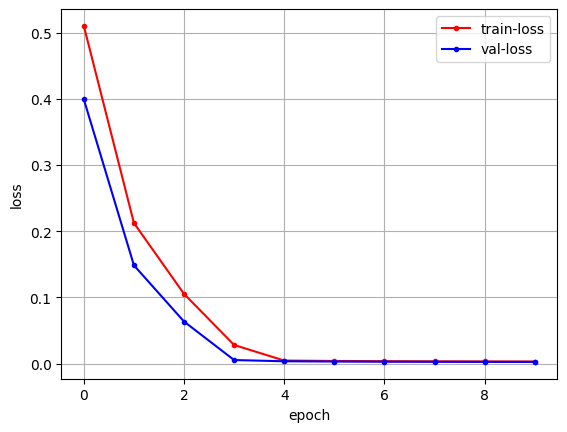

In [33]:
#%% Train the Model

# TODO**
loss_epoch_train = []
loss_epoch_val = []
for epoch in range(num_epochs):
    loss_seq_train = []
    loss_seq_val = []
    
    for seq, labels in train_inout_seq:
        seq, labels = seq.to(device), labels.to(device)
        net.hidden = net.init_hidden()
        optimizer.zero_grad()
        y_pred_train = net(seq)
        
        seq_loss = loss_function(y_pred_train, labels)
        loss_seq_train.append(seq_loss.data.cpu().numpy())
        seq_loss.backward()
        optimizer.step()
        
       
    for seq, labels in val_inout_seq:
        seq, labels = seq.to(device), labels.to(device)
        y_pred_val = net(seq)
        
        seq_loss = loss_function(y_pred_val, labels)
        loss_seq_val.append(seq_loss.data.cpu().numpy())
        
    loss_epoch_train.append(np.mean(loss_seq_train))
    loss_epoch_val.append(np.mean(loss_seq_val))
    print('Epoch '+str(epoch)+'/'+str(num_epochs)+': Train-Loss: '+str(np.round(loss_epoch_train[-1],4))+'; Val-Loss: '+str(np.round(loss_epoch_val[-1],4)))        
    
plt.figure()
plt.plot(range(num_epochs), loss_epoch_train, color='r', marker='.', label = 'train-loss')
plt.plot(range(num_epochs), loss_epoch_val, color='b', marker='.', label = 'val-loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.savefig('../results/lstm_loss.png')
plt.show()

---

## Testing

With the trained LSTM model we can now make predictions about future values. However, the model always expects as input a sequence of the length of *train_window*. To predict point $x_{t+1}$ we can simply take the last *train_window* values of the *trva_data*. To predict point $x_{t+2}$ we have to delete the first *trva_data* point and insert the previous test point $x_{t+1}$ at the end. This is repeated as often as desired in *fut_pred*. Note that this procedure is also well suited for other tasks, for example to close data gaps.

**9. TODO**:  Change the value for **fut_pred** and describe how the values behave which are long in the future. Save the corresponding plot.

...

**10. TODO**: Optimize the parameters of the network in such a way that the *test_data* are satisfactorily approximated. Crucial parameters are *train_window, hidden_dim*, and *num_lstm_layers*. Save this state for submission.

In [34]:
# Make predictions
# TODO**
fut_pred = 10

# The last train_window trva data are the first input for the prediction...
test_inputs = trva_data_normalized[-train_window:].tolist()
print(test_inputs)

# ...and each new prediction is append to the input
net.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    seq = seq.to(device)
    with torch.no_grad():
        net.hidden = net.init_hidden()
        test_inputs.append(net(seq).item())

# Print only the predictions (the last fut_pred elements in the list)
print(test_inputs[-fut_pred:])


# Since we normalized the dataset for training the predicted values are also normalized
# Undo with inverse normalization
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[1.0, -0.9920039772987366, -0.9820089936256409, -0.9940029978752136, -0.9440279603004456, -0.6821589469909668, 1.0, -0.9920039772987366, -0.9820089936256409, -0.977011501789093, -0.9640179872512817, -0.40529733896255493, 1.0, -0.9920039772987366, -0.9810094833374023, -0.9840080142021179, -0.9840080142021179, -0.4682658612728119, 1.0, -0.9920039772987366, -0.9800099730491638, -0.9920039772987366, -0.9440279603004456, -0.670164942741394]
[1.000098705291748, -0.9449083209037781, -0.977048933506012, -0.9908636212348938, -0.9760979413986206, -0.5173027515411377, 0.9763889908790588, -0.9416117668151855, -0.9743189215660095, -0.9856056571006775]
[[2001.09875464]
 [  55.11922494]
 [  22.96254203]
 [   9.14094695]
 [  23.91400963]
 [ 482.93859708]
 [1977.37718537]
 [  58.4174273 ]
 [  25.69391897]
 [  14.40154007]]


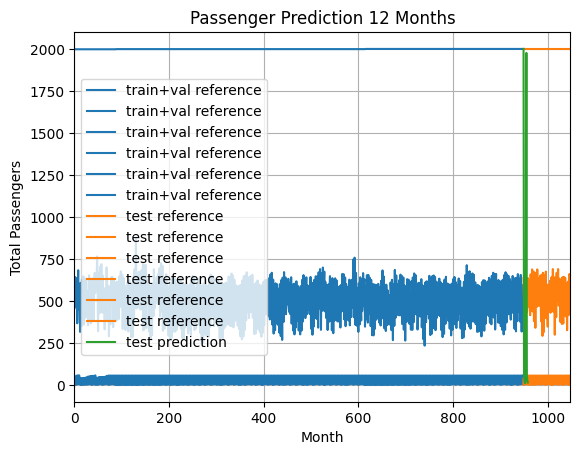

In [38]:
#%% plot for whole time window
plt.title('Passenger Prediction 12 Months')
plt.xlabel('Month')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(trva_data, color='#1f77b4', label='train+val reference')
x_ref = np.arange(trva_data.shape[0], trva_data.shape[0]+test_data.shape[0], 1)
x_pred = np.arange(trva_data.shape[0], trva_data.shape[0]+fut_pred, 1)
plt.plot(x_ref,test_data, color='#ff7f0e', label='test reference')
plt.plot(x_pred,actual_predictions, color='#2ca02c', label='test prediction')
plt.savefig("../results/lstm_forecast.png")
plt.legend()
plt.show()

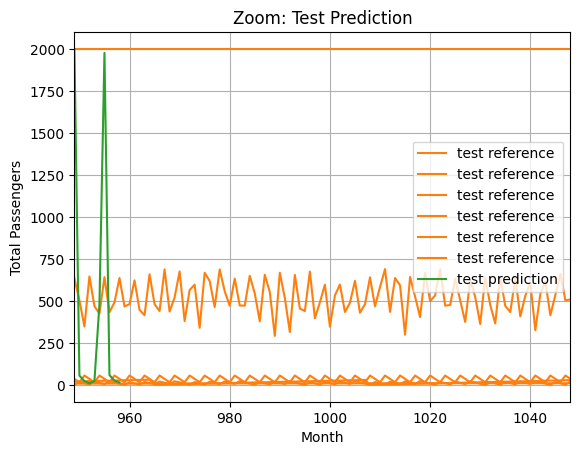

In [39]:
# Zoom plot for test area
plt.title('Zoom: Test Prediction')
plt.xlabel('Month')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_ref,test_data, color='#ff7f0e', label='test reference')
plt.plot(x_pred,actual_predictions, color='#2ca02c', label='test prediction')
plt.savefig('../results/lstm_test_zoom.png')
plt.legend()
plt.show()